In [1]:
import time
import numpy as np

from basic_model import M_model
import torch
from torch import optim
from util import bce_loss, accuracy_function
from Paras import Para

from data_loader import train_loader, validation_loader, test_loader

Para.dataset_len = len(train_loader)
Para.log_step = len(train_loader) // 4

optimizer = torch.optim.RMSprop(M_model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
Para.epoch_num = 60

def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()
    train_loss = 0.
    accuracy = 0.
    batch_num = len(train_loader)
    _index = 0

    for _index, data in enumerate(train_loader):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        predicted = model(spec_input)

        loss_value = bce_loss(predicted, target)
        accuracy_value = accuracy_function(predicted, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value.data.item()
        accuracy += accuracy_value

        if versatile:
            if (_index + 1) % Para.log_step == 0:
                elapsed = time.time() - start_time
                print('Epoch{:3d} | {:3d}/{:3d} batches | {:5.2f}ms/ batch | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
                      .format(epoch, _index + 1, batch_num,
                              elapsed * 1000 / (_index + 1),
                              train_loss / (_index + 1),
                              accuracy * 100 / (_index + 1)))

    train_loss /= (_index + 1)
    accuracy /= (_index + 1)

    print('-' * 99)
    print('End of training epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
          .format(epoch, (time.time() - start_time),
                  train_loss, accuracy * 100))

    return train_loss, accuracy


def validate_test(model, epoch, test=False):
    start_time = time.time()
    model = model.eval()
    v_loss = 0.
    accuracy = 0.
    data_loader_use = validation_loader if not test else test_loader
    _index = 0
    for _index, data in enumerate(data_loader_use):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        with torch.no_grad():

            predicted = model(spec_input)

            loss_value = bce_loss(predicted, target)
            accuracy_value = accuracy_function(predicted, target)

            v_loss += loss_value.data.item()
            accuracy += accuracy_value

    v_loss /= (_index + 1)
    accuracy /= (_index + 1)

    if not test:
        print('End of validation epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
              .format(epoch, (time.time() - start_time),
                v_loss, accuracy * 100))
    else:
        print('End of Test | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
              .format((time.time() - start_time),
                v_loss, accuracy * 100))
    print('-' * 99)

    return v_loss, accuracy

# Train the model here

In [2]:
Para.cuda

True

In [3]:
t_loss, t_accu, v_loss, v_accu = [], [], [], []
decay_cnt = 0

for epoch in range(1, Para.epoch_num + 1):
    if Para.cuda:
        M_model.cuda()

    train_loss, train_accuracy = train(M_model, epoch)
    validation_loss, validation_accuracy = validate_test(M_model, epoch, test=False)

    t_loss.append(train_loss)
    t_accu.append(train_accuracy)

    v_loss.append(validation_loss)
    v_accu.append(validation_accuracy)

    # use accuracy to find the best model
    if np.max(t_accu) == t_accu[-1]:
        print('***Found Best Training Model***')
    if np.max(v_accu) == v_accu[-1]:
        with open(Para.MODEL_SAVE_PATH_1, 'wb') as f:
            torch.save(M_model.cpu().state_dict(), f)
            print('***Best Validation Model Found and Saved***')

    print('-' * 99)

    # Use BCE loss value for learning rate scheduling
    decay_cnt += 1

    if np.min(t_loss) not in t_loss[-3:] and decay_cnt > 2:
        scheduler.step()
        decay_cnt = 0
        print('***Learning rate decreased***')
        print('-' * 99)

Epoch  1 |  87/350 batches | 18.58ms/ batch | BCE: 0.3155 | Accuracy: 20.04% |
Epoch  1 | 174/350 batches | 18.07ms/ batch | BCE: 0.3093 | Accuracy: 21.84% |
Epoch  1 | 261/350 batches | 17.90ms/ batch | BCE: 0.3055 | Accuracy: 23.06% |
Epoch  1 | 348/350 batches | 17.81ms/ batch | BCE: 0.3026 | Accuracy: 24.01% |
---------------------------------------------------------------------------------------------------
End of training epoch   1 | time:  6.25s | BCE: 0.3026 | Accuracy: 24.04% |
End of validation epoch   1 | time:  0.38s | BCE: 0.2784 | Accuracy: 37.41% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch  2 |  87/350 batches | 18.11ms/ batch | BCE: 0.2862 | Accuracy: 30.68% |
Epoch  2 | 174/350 batches | 17.83ms/ batch | BCE: 0.2824 | Accuracy: 31.11

Epoch 11 |  87/350 batches | 18.11ms/ batch | BCE: 0.1909 | Accuracy: 59.63% |
Epoch 11 | 174/350 batches | 17.85ms/ batch | BCE: 0.1891 | Accuracy: 60.49% |
Epoch 11 | 261/350 batches | 17.73ms/ batch | BCE: 0.1885 | Accuracy: 60.27% |
Epoch 11 | 348/350 batches | 17.70ms/ batch | BCE: 0.1878 | Accuracy: 60.31% |
---------------------------------------------------------------------------------------------------
End of training epoch  11 | time:  6.22s | BCE: 0.1877 | Accuracy: 60.36% |
End of validation epoch  11 | time:  0.35s | BCE: 0.1644 | Accuracy: 66.24% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch 12 |  87/350 batches | 18.15ms/ batch | BCE: 0.1740 | Accuracy: 62.93% |
Epoch 12 | 174/350 batches | 17.88ms/ batch | BCE: 0.1794 | Accuracy: 62.00

Epoch 21 |  87/350 batches | 18.26ms/ batch | BCE: 0.1287 | Accuracy: 74.64% |
Epoch 21 | 174/350 batches | 17.95ms/ batch | BCE: 0.1255 | Accuracy: 75.68% |
Epoch 21 | 261/350 batches | 17.80ms/ batch | BCE: 0.1245 | Accuracy: 75.67% |
Epoch 21 | 348/350 batches | 17.75ms/ batch | BCE: 0.1256 | Accuracy: 75.22% |
---------------------------------------------------------------------------------------------------
End of training epoch  21 | time:  6.23s | BCE: 0.1255 | Accuracy: 75.27% |
End of validation epoch  21 | time:  0.34s | BCE: 0.1192 | Accuracy: 75.57% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch 22 |  87/350 batches | 18.18ms/ batch | BCE: 0.1226 | Accuracy: 75.72% |
Epoch 22 | 174/350 batches | 17.95ms/ batch | BCE: 0.1210 | Accuracy: 76.36

Epoch 31 |  87/350 batches | 18.21ms/ batch | BCE: 0.0808 | Accuracy: 85.92% |
Epoch 31 | 174/350 batches | 17.87ms/ batch | BCE: 0.0834 | Accuracy: 84.84% |
Epoch 31 | 261/350 batches | 17.78ms/ batch | BCE: 0.0826 | Accuracy: 84.96% |
Epoch 31 | 348/350 batches | 17.72ms/ batch | BCE: 0.0818 | Accuracy: 85.17% |
---------------------------------------------------------------------------------------------------
End of training epoch  31 | time:  6.23s | BCE: 0.0819 | Accuracy: 85.12% |
End of validation epoch  31 | time:  0.38s | BCE: 0.0955 | Accuracy: 80.59% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
---------------------------------------------------------------------------------------------------
Epoch 32 |  87/350 batches | 18.08ms/ batch | BCE: 0.0819 | Accuracy: 85.34% |
Epoch 32 | 174/350 batches | 17.80ms/ batch | BCE: 0.0801 | Accuracy: 85.78% |
Epoch 32 | 261/350 batches | 17.72ms/ ba

Epoch 41 |  87/350 batches | 18.41ms/ batch | BCE: 0.0468 | Accuracy: 92.53% |
Epoch 41 | 174/350 batches | 17.99ms/ batch | BCE: 0.0480 | Accuracy: 92.39% |
Epoch 41 | 261/350 batches | 17.83ms/ batch | BCE: 0.0470 | Accuracy: 92.60% |
Epoch 41 | 348/350 batches | 17.75ms/ batch | BCE: 0.0484 | Accuracy: 92.31% |
---------------------------------------------------------------------------------------------------
End of training epoch  41 | time:  6.24s | BCE: 0.0484 | Accuracy: 92.34% |
End of validation epoch  41 | time:  0.39s | BCE: 0.0785 | Accuracy: 84.28% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch 42 |  87/350 batches | 18.18ms/ batch | BCE: 0.0479 | Accuracy: 92.67% |
Epoch 42 | 174/350 batches | 17.90ms/ batch | BCE: 0.0481 | Accuracy: 92.64

Epoch 51 |  87/350 batches | 18.17ms/ batch | BCE: 0.0255 | Accuracy: 96.55% |
Epoch 51 | 174/350 batches | 17.87ms/ batch | BCE: 0.0259 | Accuracy: 96.23% |
Epoch 51 | 261/350 batches | 17.80ms/ batch | BCE: 0.0259 | Accuracy: 96.10% |
Epoch 51 | 348/350 batches | 17.77ms/ batch | BCE: 0.0255 | Accuracy: 96.30% |
---------------------------------------------------------------------------------------------------
End of training epoch  51 | time:  6.24s | BCE: 0.0255 | Accuracy: 96.30% |
End of validation epoch  51 | time:  0.34s | BCE: 0.0683 | Accuracy: 86.74% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch 52 |  87/350 batches | 18.31ms/ batch | BCE: 0.0270 | Accuracy: 96.41% |
Epoch 52 | 174/350 batches | 17.92ms/ batch | BCE: 0.0238 | Accuracy: 97.02

In [4]:
import matplotlib.pyplot as plt

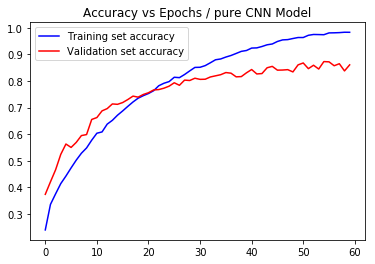

In [5]:
# visualization
plt.figure()
plt.plot(t_accu, c='b', label='Training set accuracy')
plt.plot(v_accu, c='r', label='Validation set accuracy')
plt.title('Accuracy vs Epochs / pure CNN Model')
plt.legend()
plt.show()

## Test Model on Test Set

In [6]:
M_model.load_state_dict(torch.load(Para.MODEL_SAVE_PATH_1))
validate_test(M_model, 0, test=True)

End of Test | time:  0.76s | BCE: 0.0832 | Accuracy: 86.17% |
---------------------------------------------------------------------------------------------------


(0.0831641211301427, 0.8617424242424242)

In [7]:
store_dict = dict()
store_dict['train_a'] = t_accu
store_dict['train_l'] = t_loss
store_dict['valid_a'] = v_accu
store_dict['valid_l'] = v_loss

In [8]:
import json
with open('train_on_old.json', 'w+') as f:
    json.dump(store_dict, f)